# Vote transfers in French presidential elections

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors,cm,colorbar
import scipy
import re

/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from IPython.display import HTML

In [24]:
from sklearn import model_selection

## Load the data

In [5]:
def cleanup(df_bur):
    df_bur=df_bur.rename(columns={'Code du département':"Code du departement",'Département':u'Departement','Prénom':'Prenom',
                              'Exprimés':'Exprimes',
                              'Coordonnées':'Coordonnees',
                              'N°Panneau':'Panneau'
                             })
    df_bur=df_bur.drop(['Prenom','Sexe'],axis=1)
    df_bur['Bureau de vote']=df_bur['Bureau de vote'].apply(lambda x:str(x)[2:] if (str(x)[:2]=='BV') else x).apply(lambda x: re.sub("^[0]+","",str(x)))
    df_bur['Code de la commune']=df_bur['Code de la commune'].apply(lambda x: re.sub("^[0]+","",str(x)))
    df_bur['Code du departement']=df_bur['Code du departement'].apply(lambda x: re.sub("^[0]+","",str(x)))
    df_bur['Code de la circonscription']=df_bur['Code de la circonscription'].apply(lambda x: re.sub("^[0]+","",str(x)))
    e1=df_bur[[u'Departement',
       u'Circonscription', u'Commune','Bureau de vote']+[u'Inscrits',u'Abstentions',                  u'% Abs/Ins',
                          u'Votants',                  u'% Vot/Ins',
                           u'Blancs',               u'% Blancs/Ins',
                     u'% Blancs/Vot',                       u'Nuls',
                       u'% Nuls/Ins',                 u'% Nuls/Vot',
                         u'Exprimes']].set_index([u'Departement',
       u'Circonscription', u'Commune', 'Bureau de vote']).drop_duplicates()
    
    df_b1=df_bur.pivot_table(index=[u'Departement',
       u'Circonscription', u'Commune', 'Bureau de vote'],columns = u'Nom',values='Voix')
    
    tab=pd.merge(df_b1,e1,left_index=True,right_index=True)
    
    if ('MÉLENCHON' in tab.columns):
        tab=tab.rename(columns={'MÉLENCHON':'MELENCHON'})
    
    return tab

#### Load the data

In [6]:
df_bur = pd.read_csv("election-presidentielle-2017-resultats-par-bureaux-de-vote-tour-1.csv",sep=';',decimal=',')
df_bur2 = pd.read_csv("election-presidentielle-2017-resultats-par-bureaux-de-vote-tour-2.csv",sep=';',decimal=',')

/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,6,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/grisha.oryol/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### and clean it up a bit

In [7]:
tab=cleanup(df_bur)

In [8]:
tab2=cleanup(df_bur2)

#### Check that the data if consistent

In [9]:
print(np.all(tab['Votants']+tab['Abstentions']-tab['Inscrits']==0))
print((tab[[u'ARTHAUD', u'ASSELINEAU', u'CHEMINADE', u'DUPONT-AIGNAN', u'FILLON',
       u'HAMON', u'LASSALLE', u'LE PEN', u'MACRON', u'POUTOU',u'MELENCHON']].sum(axis=1)-tab[u'Exprimes']!=0).sum())
print((tab[[u'ARTHAUD', u'ASSELINEAU', u'CHEMINADE', u'DUPONT-AIGNAN', u'FILLON',
       u'HAMON', u'LASSALLE', u'LE PEN', u'MACRON', u'POUTOU',u'MELENCHON', u'Blancs',u'Nuls']].sum(axis=1)-tab[u'Votants']!=0).sum())

True
0
0


#### merge the results of two rounds into one table

In [10]:
merged=pd.merge(tab,tab2,left_index=True,right_index=True,how='inner')

Here we merge into one cathegory voters which voted blanc, voters which voted nul and 
registered voters which abstained. We also merge into one cathegory the five least successful candidates .
This step is not strictly necessary, but there are two reasons for doing it: first, with less cathegories
there are less parameters to tune and the model turns out more robust. Second, the shares of votes corresponding to 
these minor cathegories are so small that they are comparable with the error of the model itself, so by including them 
we won't get any reliable new information

In [13]:
merged['Abstention, blanc, nul']=merged[['Blancs_y','Nuls_y','Abstentions_y']].sum(axis=1)
merged['Abstention, blanc, nul_x']=merged[['Blancs_x','Nuls_x','Abstentions_x']].sum(axis=1)
merged['Other candidates']=merged[['ARTHAUD','ASSELINEAU','CHEMINADE','LASSALLE','POUTOU']].sum(axis=1)

In [14]:
nms_compressed=['Other candidates',
 u'DUPONT-AIGNAN',
 u'FILLON',
 u'HAMON',
 u'LE PEN_x',
 u'MELENCHON',
 'MACRON_x','Abstention, blanc, nul_x']

In [15]:
options_2iem_compressed=['LE PEN_y', 'MACRON_y', 'Abstention, blanc, nul']

## Optimization procedure

In [16]:
def optimize(merged):
    print('opimizing, input table has '+str(merged.shape[0])+" rows")
    y1=(merged[options_2iem_compressed].T/merged['Inscrits_y']).T[merged['Inscrits_x']!=0]
    X1=(merged[nms_compressed].T/merged['Inscrits_x']).T[merged['Inscrits_x']!=0]
    n_2iem=len(options_2iem_compressed)
    def rshp(prob):
        tmp1=np.reshape(prob,(len(options_2iem_compressed)-1,X1.shape[1])).T
        tmp2=np.concatenate((tmp1,np.array([1-tmp1.sum(axis=1)]).T),axis=1)
        return(tmp2)

    def loss_func(prob):
        #lst=np.split(prob,len(options_2iem)-1)
        y1=(merged[options_2iem_compressed].T/merged['Inscrits_y']).T[merged['Inscrits_x']!=0]
        tmp2=rshp(prob)
        ret=np.sum((np.dot(X1,tmp2)-y1)**2).sum()
        return ret
    def fun_constr(prob):
        return 1-np.reshape(prob,(n_2iem-1,X1.shape[1])).sum(axis=0)
    bs=[(0,1)]*(X1.shape[1])*(n_2iem-1)
    x0=np.array(X1.shape[1]*(n_2iem-1)*[0.2])
    constr={'type':'ineq','fun':fun_constr}
    opt=scipy.optimize.minimize(loss_func,
                   x0,#jac=jac,
                   method = 'SLSQP',
                   bounds = bs,
                   constraints = constr

        )
    print(opt)
    print('error: '+str(np.sqrt(opt.fun/len(y1))))
    res=pd.DataFrame(rshp(opt.x),columns=options_2iem_compressed,index=nms_compressed).round(3)
    return(res)

In [17]:
res_c=optimize(merged)

opimizing, input table has 67086 rows
     fun: 263.9150962426472
     jac: array([ -6.59942627e-03,   5.11169434e-04,  -1.07574463e-02,
         1.97242279e+01,  -6.33101425e+01,   5.07683563e+00,
         6.11039886e+01,  -2.21366882e-02,   2.07901001e-03,
         3.40237427e+00,   2.37121582e-02,  -1.57351341e+01,
         2.79375237e+02,   2.06604004e-02,  -9.10418243e+01,
         2.75230408e-02,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 429
     nit: 23
    njev: 23
  status: 0
 success: True
       x: array([  3.20825690e-01,   5.95711137e-01,   1.26343719e-01,
         0.00000000e+00,   9.99999999e-01,   3.47440410e-10,
         0.00000000e+00,   6.69247230e-02,   2.57538331e-01,
         1.10623686e-10,   5.93119167e-01,   1.00000000e+00,
         0.00000000e+00,   5.29850020e-01,   1.00000000e+00,
         1.09478907e-01])
error: 0.0627219287052


#### Let us see how the results change if we take two different subsets of the original data

In [34]:
splitter = model_selection.ShuffleSplit(1,0.1)
train = merged.iloc[[x for x in splitter.split(merged)][0][0]]

In [35]:
res_train=optimize(train)

opimizing, input table has 60377 rows
     fun: 237.89965379167091
     jac: array([ -1.80435181e-03,   3.81469727e-04,   2.02560425e-03,
         1.76996803e+01,  -5.60079422e+01,   4.44985199e+00,
         5.41940422e+01,   8.15200806e-03,   1.49154663e-03,
         2.93554688e+00,   4.87899780e-03,  -1.46689796e+01,
         2.53004669e+02,   7.30514526e-03,  -8.24138451e+01,
         8.51440430e-03,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 412
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([  3.19103954e-01,   5.99046763e-01,   1.26264289e-01,
         3.55008803e-10,   1.00000000e+00,   0.00000000e+00,
         9.60786308e-10,   6.68259548e-02,   2.64664819e-01,
         0.00000000e+00,   5.92685526e-01,   1.00000000e+00,
         3.11596829e-09,   5.27829035e-01,   9.99999999e-01,
         1.10083651e-01])
error: 0.0627718222829


In [36]:
splitter = model_selection.ShuffleSplit(1,0.1)
train = merged.iloc[[x for x in splitter.split(merged)][0][0]]

In [37]:
res_train1=optimize(train)

opimizing, input table has 60377 rows
     fun: 238.4550824444297
     jac: array([  3.98635864e-04,  -1.55830383e-03,   8.17489624e-03,
         1.74214668e+01,  -5.60459957e+01,   3.85927010e+00,
         5.33163280e+01,   3.02696228e-03,  -1.44958496e-03,
         3.04081154e+00,  -8.88824463e-03,  -1.41430283e+01,
         2.51878880e+02,  -1.26762390e-02,  -8.36517258e+01,
        -1.65290833e-02,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 412
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([  3.17673002e-01,   5.94661446e-01,   1.26227630e-01,
         0.00000000e+00,   9.99999999e-01,   3.37464405e-10,
         0.00000000e+00,   6.76501068e-02,   2.60531533e-01,
         9.74648594e-11,   5.92327278e-01,   1.00000000e+00,
         0.00000000e+00,   5.28642591e-01,   1.00000000e+00,
         1.10231128e-01])
error: 0.0628450568204


In [38]:
res_train1-res_train

,LE PEN_y,MACRON_y,"Abstention, blanc, nul"
Other candidates,-0.001,-0.004,0.006
DUPONT-AIGNAN,-0.004,0.000,0.004
FILLON,0.000,-0.001,0.000
HAMON,0.000,0.000,0.000
LE PEN_x,0.000,0.000,0.000
MELENCHON,0.000,0.001,-0.001
MACRON_x,0.000,0.000,0.000
"Abstention, blanc, nul_x",0.001,0.000,-0.001


## Visualization of the results

In [39]:
res_premier=merged[nms_compressed].sum()/merged['Inscrits_x'].sum()

In [40]:
res_new=((res_premier*res_c.T).T).round(3)

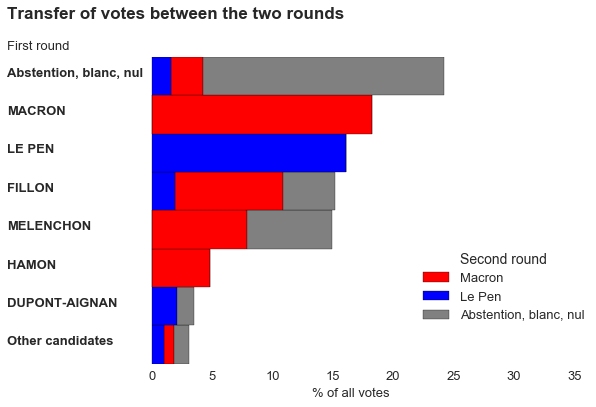

In [43]:
def form(x): 
    return x if ((len(x)<2) or ((x[len(x)-2:]!='_x') and  (x[len(x)-2:]!='_y') )) else x[:len(x)-2]
chart1=res_new.copy()
chart1['total']=chart1.sum(axis=1)
chart1=chart1.sort_values(['total'])*100
bar_h=10
x_init=0.12*100
fig=plt.figure(facecolor='white')
ax=fig.add_subplot(111)
ax.set_axis_bgcolor('white')
ax.text(0,bar_h*len(chart1.index)+bar_h*0.2,'First round',fontsize=13)
for i in range(len(chart1.index)):
    ax.bar(x_init+chart1.iloc[i,0],bar_h,chart1.iloc[i,1],bottom=bar_h*i,color='red')
    ax.bar(x_init,bar_h,chart1.iloc[i,0],bottom=bar_h*i,color='blue')
    ax.bar(x_init+chart1.iloc[i,0]+chart1.iloc[i,1],bar_h,chart1.iloc[i,2],bottom=bar_h*i,color='grey')
    ax.text(0,bar_h*i+bar_h*0.5,form(chart1.index[i]),fontweight='bold',fontsize=13)
lg=ax.legend(['Macron','Le Pen','Abstention, blanc, nul'],loc=(0.65,0.12),title='Second round',fontsize=13)
plt.setp(lg.get_title(),fontsize=14)
ax.set_yticks([])
ticks=np.arange(0,40,5)
ax.set_xticks(ticks+x_init)
ax.set_xticklabels([str(x) for x in ticks],fontsize=13)
ax.text(0,bar_h*(len(chart1.index)+1),'Transfer of votes between the two rounds',
             fontweight='bold',
             fontsize=17
             )
ax.set_xlabel('% of all votes',fontsize=13)
plt.show()

#### The table containing percents of vote transfers

In [50]:
table_html=(pd.DataFrame(np.array(res_c),columns=['Le Pen','Macron','Abstention, blanc, nul'],
             index=['Other candidates','Dupont-Aignan','Fillon','Hamon',
                    'Le Pen','Mélenchon','Macron','Abstention, blanc, nul']).sort_values('Macron',ascending=False)*100).round(1).to_html()
      

In [51]:
HTML(table_html)

,Le Pen,Macron,"Abstention, blanc, nul"
Hamon,0.0,100.0,0.0
Macron,0.0,100.0,0.0
Fillon,12.6,59.3,28.1
Mélenchon,0.0,53.0,47.0
Other candidates,32.1,25.8,42.2
"Abstention, blanc, nul",6.7,10.9,82.4
Dupont-Aignan,59.6,0.0,40.4
Le Pen,100.0,0.0,0.0


# Turnout

Here we look at how voters' engagement at different polling stations is related to their preference for particular candidates.
Some candidates see their scores grow with turnout, for others it's the opposite

In [69]:
candidates_maj=[
 u'FILLON',
 u'HAMON',
 u'LE PEN',
  'MACRON',
 u'MELENCHON'
 ]

#### First round

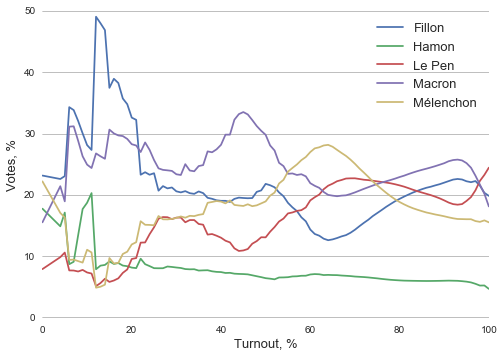

In [70]:
window=10
tab['tmp']=100-(tab['% Abs/Ins']).astype('int')
by_turnout=(tab.groupby('tmp')[candidates_maj+['Inscrits','Votants','Blancs','Nuls']]).sum().rolling(window=window,
                                            center=True,min_periods=0).mean(how='forward')
fig=plt.figure(facecolor='white')
ax=fig.add_subplot(111)
ax.set_axis_bgcolor('white')
(100*(by_turnout[candidates_maj].T/by_turnout['Votants'])).T.plot(ax=ax)
ax.legend(['Fillon','Hamon','Le Pen','Macron',u'Mélenchon'],fontsize=13)
ax.set_xlabel('Turnout, %',fontsize=13)
ax.set_ylabel('Votes, %',fontsize=13)
ax.grid(b=True,axis='y',color='grey',linewidth=0.5)
ax.axhline(y=0.1,color='grey',linewidth=0.5)
plt.show()

#### Second round

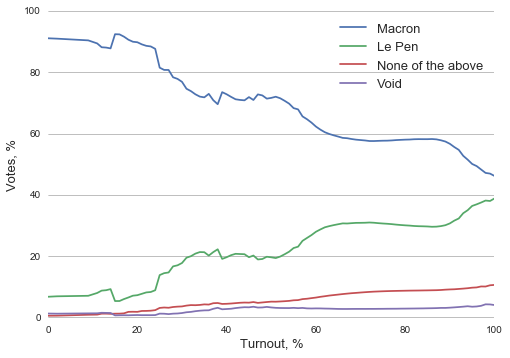

In [71]:
window=10
tab2['tmp']=100-(tab2['% Abs/Ins']).astype('int')
by_turnout=(tab2.groupby('tmp')[['MACRON','LE PEN','Blancs','Nuls','Votants']]).sum().rolling(window=window,
                                            center=True,min_periods=0).mean(how='forward')
fig=plt.figure(facecolor='white')
ax=fig.add_subplot(111)
ax.set_axis_bgcolor('white')
(100*(by_turnout[['MACRON','LE PEN','Blancs','Nuls']].T/by_turnout['Votants'])).T.plot(ax=ax)
ax.legend(['Macron','Le Pen','None of the above','Void'],fontsize=13)
ax.set_xlabel('Turnout, %',fontsize=13)
ax.set_ylabel('Votes, %',fontsize=13)
ax.grid(b=True,axis='y',color='grey',linewidth=0.5)
ax.axhline(y=0.1,color='grey',linewidth=0.5)
plt.show()